This notebook initializes the CARLA client, spawns the ego vehicle (Tesla Model 3), and attaches sensors(RGB Camera,Lidar, and GPS), runs a simulation loop with  autopilot enabled to log data to a csv file for processing.



In [14]:
import carla
import random
import time
import numpy as np
import cv2
from datetime import datetime

# Connect to CARLA server
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)

# Get the world
world = client.get_world()
blueprint_library = world.get_blueprint_library()

print(f"Current map: {world.get_map().name}")

Current map: Carla/Maps/Town10HD_Opt


## Step 2: Spawn a Vehicle

This creates a Tesla Model 3 at a random spawn point.

In [3]:
# Get Tesla Model 3 blueprint
vehicle_bp = blueprint_library.filter('model3')[0]

# Get a random spawn point from the map
spawn_points = world.get_map().get_spawn_points()
spawn_point = random.choice(spawn_points)

# Spawn the vehicle
vehicle = world.spawn_actor(vehicle_bp, spawn_point)

# Enable autopilot
vehicle.set_autopilot(True)

# Keep track of actors to clean up later
actors_list = [vehicle]

In [ ]:
# Quick Spectator Snap
spectator = world.get_spectator()
transform = vehicle.get_transform()

# Position the camera 5 meters behind and 3 meters above the car
spectator_location = transform.location + carla.Location(z=3.0) - transform.get_forward_vector() * 5.0
spectator.set_transform(carla.Transform(spectator_location, transform.rotation))

In [5]:
# Global storage for sensor data
sensor_data = {
    'camera_image': None,
    'lidar_points': 0,
    'min_distance': float('inf'),
    'gps_lat': 0.0,
    'gps_lon': 0.0,
    'gps_alt': 0.0
}

Camera Sensor

In [6]:
# Defines what happens when camera gets new data
def camera_callback(image):
    # Convert CARLA image to numpy array
    array = np.frombuffer(image.raw_data, dtype=np.uint8)
    array = np.reshape(array, (image.height, image.width, 4))  # BGRA
    array = array[:, :, :3]  # Remove alpha channel, keep BGR
    #switch to RGB
    array = array[:, :, ::-1]

    sensor_data['camera_image'] = array

# Get camera blueprint
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '800')
camera_bp.set_attribute('image_size_y', '600')
camera_bp.set_attribute('fov', '90')

# Position: 1.5m in front, 2.4m above the vehicle center
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))

# Spawn and attach to vehicle
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
camera.listen(camera_callback)
actors_list.append(camera)


Lidar Sensor


In [7]:
import math

# Defines what happens when lidar gets new data
def lidar_callback(point_cloud):
    # Count number of points in the point cloud
    sensor_data['lidar_points'] = len(point_cloud)
    # Calculate minimum distance to closest object
    if len(point_cloud) > 0:
        distances = [math.sqrt(p.point.x**2 + p.point.y**2 + p.point.z**2) for p in point_cloud]
        sensor_data['min_distance'] = min(distances)
    else:
        sensor_data['min_distance'] = float('inf')

# Get lidar blueprint
lidar_bp = blueprint_library.find('sensor.lidar.ray_cast')
lidar_bp.set_attribute('channels', '32')  # 32 vertical channels
lidar_bp.set_attribute('range', '50')     # 50 meters max range
lidar_bp.set_attribute('points_per_second', '56000')
lidar_bp.set_attribute('rotation_frequency', '10')  # 10 Hz

# Position: on top of vehicle 2.5m above center
lidar_transform = carla.Transform(carla.Location(x=0.0, z=2.5))

# Spawn and attach to vehicle
lidar = world.spawn_actor(lidar_bp, lidar_transform, attach_to=vehicle)
lidar.listen(lidar_callback)
actors_list.append(lidar)


GPS Sensor

In [8]:
# Defines what happens when GPS gets new data
def gps_callback(gps_data):
    sensor_data['gps_lat'] = gps_data.latitude
    sensor_data['gps_lon'] = gps_data.longitude
    sensor_data['gps_alt'] = gps_data.altitude

# Get GPS blueprint
gps_bp = blueprint_library.find('sensor.other.gnss')

# Position: at vehicle center
gps_transform = carla.Transform(carla.Location(x=0.0, z=0.0))

# Spawn and attach to vehicle
gps = world.spawn_actor(gps_bp, gps_transform, attach_to=vehicle)
gps.listen(gps_callback)
actors_list.append(gps)


Collect Sensor Data

In [11]:
import csv

print("data collection for 20 seconds...\n")

time.sleep(2)

csv_filename = f"sensor_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
csv_file = open(csv_filename, mode='w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Time_s', 'Speed_kmh', 'GPS_Lat', 'GPS_Lon', 'GPS_Alt', 'Lidar_Points', 'Min_Distance_m'])

spectator = world.get_spectator()
start_time = time.time()
last_log_time = start_time
duration = 20

try:
    while time.time() - start_time < duration:
        world.wait_for_tick() 
        
        current_time = time.time()
        
        # Update Spectator Camera every single frame
        transform = vehicle.get_transform()
        spectator_location = transform.location + carla.Location(z=3.0) - transform.get_forward_vector() * 5.0
        spectator.set_transform(carla.Transform(spectator_location, transform.rotation))

        # Data Logging every 0.5s
        if current_time - last_log_time >= 0.5:
            elapsed = current_time - start_time
            
            # Get Speed
            velocity = vehicle.get_velocity()
            speed_kmh = 3.6 * np.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2)
            
            # Format minimum distance
            min_dist = sensor_data['min_distance']
            min_str = f"{min_dist:.2f}m" if min_dist != float('inf') else "N/A"
            
            print(f"[{elapsed:5.1f}s] Speed: {speed_kmh:4.1f} km/h | "
                  f"GPS: ({sensor_data['gps_lat']:.6f}, {sensor_data['gps_lon']:.6f}, {sensor_data['gps_alt']:.1f}m) | "
                  f"Lidar: {sensor_data['lidar_points']:5d} pts (Min: {min_str})")
            
            csv_writer.writerow([
                round(elapsed, 1), 
                round(speed_kmh, 2), 
                sensor_data['gps_lat'], 
                sensor_data['gps_lon'], 
                sensor_data['gps_alt'],
                sensor_data['lidar_points'],
                round(min_dist, 2) if min_dist != float('inf') else -1
            ])
            
            last_log_time = current_time
        
except KeyboardInterrupt:
    print("Stopped")
finally:
    csv_file.close()
    print(f"Saved to {csv_filename}")

data collection for 20 seconds...

[  0.5s] Speed: 30.0 km/h | GPS: (-0.000415, -0.000469, 0.0m) | Lidar:   328 pts (Min: 5.00m)
[  1.0s] Speed: 29.9 km/h | GPS: (-0.000452, -0.000469, 0.0m) | Lidar:   303 pts (Min: 5.00m)
[  1.5s] Speed: 28.7 km/h | GPS: (-0.000489, -0.000469, 0.0m) | Lidar:   306 pts (Min: 5.00m)
[  2.0s] Speed: 28.5 km/h | GPS: (-0.000525, -0.000468, 0.0m) | Lidar:   304 pts (Min: 5.00m)
[  2.5s] Speed: 28.9 km/h | GPS: (-0.000562, -0.000468, 0.0m) | Lidar:   320 pts (Min: 5.00m)
[  3.0s] Speed: 29.2 km/h | GPS: (-0.000598, -0.000468, 0.0m) | Lidar:   329 pts (Min: 5.00m)
[  3.5s] Speed: 29.3 km/h | GPS: (-0.000635, -0.000468, 0.0m) | Lidar:   357 pts (Min: 5.00m)
[  4.0s] Speed: 29.2 km/h | GPS: (-0.000672, -0.000468, 0.0m) | Lidar:   357 pts (Min: 5.00m)
[  4.6s] Speed: 29.1 km/h | GPS: (-0.000709, -0.000468, 0.0m) | Lidar:   314 pts (Min: 5.00m)
[  5.1s] Speed: 29.1 km/h | GPS: (-0.000746, -0.000468, 0.0m) | Lidar:   235 pts (Min: 5.00m)
[  5.6s] Speed: 29.1 km/h

Display Camera Image


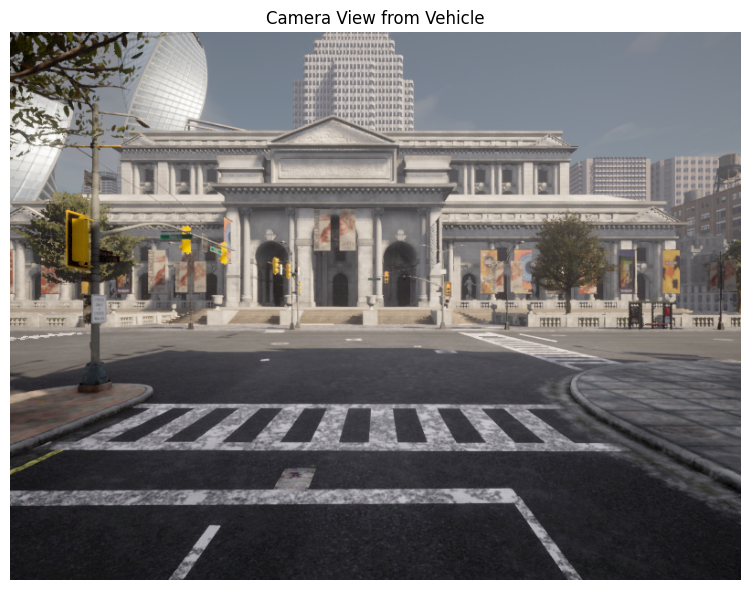

Camera resolution: 800x600


In [ ]:
import matplotlib.pyplot as plt

if sensor_data['camera_image'] is not None:
    plt.figure(figsize=(12, 6))
    plt.imshow(sensor_data['camera_image'])
    plt.title('Camera View from Vehicle')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Camera resolution: {sensor_data['camera_image'].shape[1]}x{sensor_data['camera_image'].shape[0]}")
else:
    print("No camera image available")

In [13]:
# Destroying actors (cleanup)

for actor in actors_list:
    if actor is not None and actor.is_alive:
        if actor.type_id.startswith('sensor'):
            actor.stop()


for actor in reversed(actors_list):
    if actor is not None and actor.is_alive:
        actor.destroy()


actors_list.clear()